In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.metrics import MeanSquaredError
# Sauvegarde et rechargement du modèle
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
# Evaluation du modèle 
from sklearn.metrics import mean_squared_error as mse

# Centrer reduire les mesures
from sklearn.preprocessing import StandardScaler

import datetime

**A. fonctions**

In [2]:
def df_to_windowed_df(dataframe, colonne,  first_date_str, last_date_str, n=5):
# Cette fonction permet d'utiliser les n prédictions précédentes comme mesures d'un enregistrement  

    print ("date de début ",first_date_str)
    print ("date de début ",last_date_str)
    print ("nombre de mesures :", n)
    
    first_date = datetime.datetime.strptime(first_date_str, '%Y-%m-%d').date()
    last_date  = datetime.datetime.strptime(last_date_str, '%Y-%m-%d').date()

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False

    while True:
        # On récupère les n+1 dernieres lignes en partant de la fin (On commence à start_date)
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        # on met tout sur une ligne 
        values = df_subset[colonne].to_numpy()
        x, y = values[:-1], values[-1]
        

        dates.append(target_date)
        X.append(x)
        Y.append(y)
        
        # Calcul de la date suivante 
        next_date = target_date + datetime.timedelta(days=1)
        
        if last_time:
            break
    
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    column_names = []
    for i in range(0, n):
        column_names.append ('t-'+ str(i))

    ret_df  = pd.DataFrame(X,columns = column_names)
    ret_df.index = dates
    ret_df['Target'] = Y
    
    return ret_df


def windowed_df_to_date_X_y(windowed_dataframe):
# Cette fonction permet de :
#     récupérer d'un coté 
#         les mesures  (X) dans la bonne shape et au bon format (float),
#         La target Y et de concerver 
#         les dates dans dates 

    df_as_np = windowed_dataframe.to_numpy()
    
    dates = windowed_dataframe.index
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

def df_to_X_y2_multi(df, window_size=6):
    
    # Cette fonction permet de :
#     transformer les enregistrements de telles sortes que pour une valeur à prédire on dispose de l'historiques  
#         en fonction de window_size. 
#        
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [r for r in df_as_np[i : i+window_size]]
        X.append(row) 
        label = df_as_np[i+window_size][0]
        y.append(label)
        
    return np.array(X), np.array(y)

**A. Lecture des données**

In [3]:
df = pd.read_csv ('./Data/df_rte.csv', sep=';', index_col=0)
# Suppression des colonnes inutiles 
df = df.drop(['TCO Thermique (%)', 'TCH Thermique (%)',
       'TCO Nucléaire (%)', 'TCH Nucléaire (%)', 'TCO Eolien (%)',
       'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)',
       'TCO Hydraulique (%)', 'TCH Hydraulique (%)', 'TCO Bioénergies (%)',
       'TCH Bioénergies (%)'], axis=1)

Données que l'on tri en fonction de la date au cas ou ... 

In [4]:
df = df.sort_values ('Date')

**B. Transformation des données** 



0) Controle des nan

In [5]:
df.isna().sum(axis=0)

Mois                      0
Date                      0
Jour_semaine              0
Code INSEE région         0
Région                    0
Consommation (MW)         0
Thermique (MW)            0
Nucléaire (MW)            0
Eolien (MW)               0
Solaire (MW)              0
Hydraulique (MW)          0
Pompage (MW)              0
Bioénergies (MW)          0
Ech. physiques (MW)       0
Production totale (MW)    0
dtype: int64

1) Transformation au format date 

In [6]:
df = df[['Date','Code INSEE région','Consommation (MW)']]

In [7]:
df.head()

,Date,Code INSEE région,Consommation (MW)
Annee,,,
2013,2013-01-01,11,399392
2013,2013-01-01,93,252371
2013,2013-01-01,84,355359
2013,2013-01-01,76,214645
2013,2013-01-01,53,121979


In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df.head()

,Date,Code INSEE région,Consommation (MW)
Annee,,,
2013,2013-01-01,11,399392
2013,2013-01-01,93,252371
2013,2013-01-01,84,355359
2013,2013-01-01,76,214645
2013,2013-01-01,53,121979


2) Agregat des données à la maille journalière 

In [10]:
df_uni = df[[ 'Date', 'Consommation (MW)']].groupby(['Date'], as_index=False).sum('Consommation (MW)')
df_uni_reg = df[['Date','Code INSEE région','Consommation (MW)']].groupby(['Date','Code INSEE région'], as_index=False).sum('Consommation (MW)')

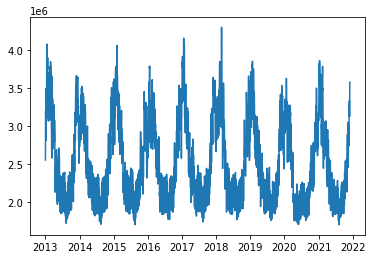

In [11]:
plt.plot(df_uni['Date'], df_uni['Consommation (MW)'])

3) La date devient l'index

In [12]:
print(" Premiere date des données utilisées : " , df_uni['Date'].min())
# 2013-01-01 00:00:00
print(" Derniere date es données utilisées  : " , df_uni['Date'].max())
# 2021-11-30 00:00:00

df_uni['Date']
df_uni.index = df_uni.pop('Date')
df_uni.head()

 Premiere date des données utilisées :  2013-01-01 00:00:00
 Derniere date es données utilisées  :  2021-11-30 00:00:00


,Consommation (MW)
Date,
2013-01-01,2556595
2013-01-02,3095594
2013-01-03,3198764
2013-01-04,3131399
2013-01-05,2886822


**C. Préparation des données pour LSTM**

In [13]:
# windowed_df = df_to_windowed_df(df_uni,
#                                 'Consommation (MW)',
#                                 '2021-01-01', 
#                                 '2021-11-30', 
#                                 n=10)

windowed_df = df_to_windowed_df(df_uni,
                                'Consommation (MW)',
                                '2018-01-01', 
                                '2019-12-31', 
                                n=15)

windowed_df.head ()

date de début  2018-01-01
date de début  2019-12-31
nombre de mesures : 15


,t-0,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,Target
2018-01-01,3227568,3492551,3604244,3567223,3383877,3193129,2864912,2796214,2788581,3029028,3158506,3324583,3335390,2874900,2666093,2702491
2018-01-02,3492551,3604244,3567223,3383877,3193129,2864912,2796214,2788581,3029028,3158506,3324583,3335390,2874900,2666093,2702491,3028933
2018-01-03,3604244,3567223,3383877,3193129,2864912,2796214,2788581,3029028,3158506,3324583,3335390,2874900,2666093,2702491,3028933,3060532
2018-01-04,3567223,3383877,3193129,2864912,2796214,2788581,3029028,3158506,3324583,3335390,2874900,2666093,2702491,3028933,3060532,3032111
2018-01-05,3383877,3193129,2864912,2796214,2788581,3029028,3158506,3324583,3335390,2874900,2666093,2702491,3028933,3060532,3032111,2991314


In [14]:
# Mise en forme de X,Y  ... sauvegarde des dates 
dates, X, y = windowed_df_to_date_X_y(windowed_df)

print (dates.shape, X.shape, y.shape) 


(730,) (730, 14, 1) (730,)


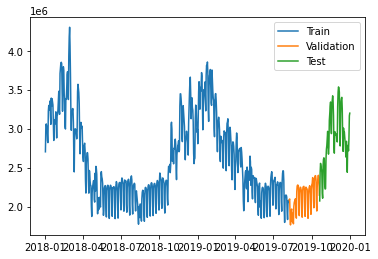

In [15]:
# Préparation des jeux de train test et val 
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [16]:
# Fabrication du model 
model = Sequential([layers.Input((X.shape[1], 1)),
                    layers.LSTM(128),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(32, activation='linear'),
                    layers.Dense(1)])

model.summary()
nommodele = 'LSTM_NAT_'+ str(datetime.datetime.now()).replace (' ','_').replace (':','_').replace ('.','_')

print("nom_du_modele : ", nommodele)

cp  = ModelCheckpoint(nommodele, save_best_only=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________
nom_du_modele :  LSTM_NAT_2022-07-15_14_57_24_303271


In [17]:
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0001),
              metrics=[MeanSquaredError()])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000)

Epoch 1/1000
19/19 [==============================] - 3s 46ms/step - loss: 7114176593920.0000 - mean_squared_error: 7114176593920.0000 - val_loss: 4572192964608.0000 - val_mean_squared_error: 4572192964608.0000
Epoch 2/1000
19/19 [==============================] - 0s 9ms/step - loss: 7114173972480.0000 - mean_squared_error: 7114173972480.0000 - val_loss: 4572190867456.0000 - val_mean_squared_error: 4572190867456.0000
Epoch 3/1000
19/19 [==============================] - 0s 10ms/step - loss: 7114171351040.0000 - mean_squared_error: 7114171351040.0000 - val_loss: 4572188246016.0000 - val_mean_squared_error: 4572188246016.0000
Epoch 4/1000
19/19 [==============================] - 0s 10ms/step - loss: 7114169253888.0000 - mean_squared_error: 7114169253888.0000 - val_loss: 4572186673152.0000 - val_mean_squared_error: 4572186673152.0000
Epoch 5/1000
19/19 [==============================] - 0s 11ms/step - loss: 7114166108160.0000 - mean_squared_error: 7114166108160.0000 - val_loss: 4572184576

Epoch 40/1000
19/19 [==============================] - 0s 10ms/step - loss: 7113532243968.0000 - mean_squared_error: 7113532243968.0000 - val_loss: 4571651375104.0000 - val_mean_squared_error: 4571651375104.0000
Epoch 41/1000
19/19 [==============================] - 0s 10ms/step - loss: 7113491349504.0000 - mean_squared_error: 7113491349504.0000 - val_loss: 4571616247808.0000 - val_mean_squared_error: 4571616247808.0000
Epoch 42/1000
19/19 [==============================] - 0s 10ms/step - loss: 7113448357888.0000 - mean_squared_error: 7113448357888.0000 - val_loss: 4571580071936.0000 - val_mean_squared_error: 4571580071936.0000
Epoch 43/1000
19/19 [==============================] - 0s 11ms/step - loss: 7113402220544.0000 - mean_squared_error: 7113402220544.0000 - val_loss: 4571542323200.0000 - val_mean_squared_error: 4571542323200.0000
Epoch 44/1000
19/19 [==============================] - 0s 9ms/step - loss: 7113355558912.0000 - mean_squared_error: 7113355558912.0000 - val_loss: 45715

Epoch 79/1000
19/19 [==============================] - 0s 9ms/step - loss: 7110557958144.0000 - mean_squared_error: 7110557958144.0000 - val_loss: 4569192988672.0000 - val_mean_squared_error: 4569192988672.0000
Epoch 80/1000
19/19 [==============================] - 0s 9ms/step - loss: 7110442614784.0000 - mean_squared_error: 7110442614784.0000 - val_loss: 4569097568256.0000 - val_mean_squared_error: 4569097568256.0000
Epoch 81/1000
19/19 [==============================] - 0s 9ms/step - loss: 7110324125696.0000 - mean_squared_error: 7110324125696.0000 - val_loss: 4569001099264.0000 - val_mean_squared_error: 4569001099264.0000
Epoch 82/1000
19/19 [==============================] - 0s 9ms/step - loss: 7110204588032.0000 - mean_squared_error: 7110204588032.0000 - val_loss: 4568902008832.0000 - val_mean_squared_error: 4568902008832.0000
Epoch 83/1000
19/19 [==============================] - 0s 9ms/step - loss: 7110082428928.0000 - mean_squared_error: 7110082428928.0000 - val_loss: 456880186

Epoch 118/1000
19/19 [==============================] - 0s 10ms/step - loss: 7104392331264.0000 - mean_squared_error: 7104392331264.0000 - val_loss: 4564127842304.0000 - val_mean_squared_error: 4564127842304.0000
Epoch 119/1000
19/19 [==============================] - 0s 10ms/step - loss: 7104188907520.0000 - mean_squared_error: 7104188907520.0000 - val_loss: 4563960070144.0000 - val_mean_squared_error: 4563960070144.0000
Epoch 120/1000
19/19 [==============================] - 0s 9ms/step - loss: 7103981813760.0000 - mean_squared_error: 7103981813760.0000 - val_loss: 4563791773696.0000 - val_mean_squared_error: 4563791773696.0000
Epoch 121/1000
19/19 [==============================] - 0s 9ms/step - loss: 7103773147136.0000 - mean_squared_error: 7103773147136.0000 - val_loss: 4563620855808.0000 - val_mean_squared_error: 4563620855808.0000
Epoch 122/1000
19/19 [==============================] - 0s 10ms/step - loss: 7103562383360.0000 - mean_squared_error: 7103562383360.0000 - val_loss: 4

19/19 [==============================] - 0s 10ms/step - loss: 7081652387840.0000 - mean_squared_error: 7081652387840.0000 - val_loss: 4545508802560.0000 - val_mean_squared_error: 4545508802560.0000
Epoch 195/1000
19/19 [==============================] - 0s 12ms/step - loss: 7081253928960.0000 - mean_squared_error: 7081253928960.0000 - val_loss: 4545180598272.0000 - val_mean_squared_error: 4545180598272.0000
Epoch 196/1000
19/19 [==============================] - 0s 11ms/step - loss: 7080847081472.0000 - mean_squared_error: 7080847081472.0000 - val_loss: 4544849772544.0000 - val_mean_squared_error: 4544849772544.0000
Epoch 197/1000
19/19 [==============================] - 0s 10ms/step - loss: 7080440758272.0000 - mean_squared_error: 7080440758272.0000 - val_loss: 4544517373952.0000 - val_mean_squared_error: 4544517373952.0000
Epoch 198/1000
19/19 [==============================] - 0s 9ms/step - loss: 7080030240768.0000 - mean_squared_error: 7080030240768.0000 - val_loss: 4544181305344.0

19/19 [==============================] - 0s 10ms/step - loss: 7042996109312.0000 - mean_squared_error: 7042996109312.0000 - val_loss: 4513922547712.0000 - val_mean_squared_error: 4513922547712.0000
Epoch 271/1000
19/19 [==============================] - 0s 10ms/step - loss: 7042373779456.0000 - mean_squared_error: 7042373779456.0000 - val_loss: 4513416085504.0000 - val_mean_squared_error: 4513416085504.0000
Epoch 272/1000
19/19 [==============================] - 0s 10ms/step - loss: 7041748303872.0000 - mean_squared_error: 7041748303872.0000 - val_loss: 4512905428992.0000 - val_mean_squared_error: 4512905428992.0000
Epoch 273/1000
19/19 [==============================] - 0s 10ms/step - loss: 7041119158272.0000 - mean_squared_error: 7041119158272.0000 - val_loss: 4512392675328.0000 - val_mean_squared_error: 4512392675328.0000
Epoch 274/1000
19/19 [==============================] - 0s 10ms/step - loss: 7040486342656.0000 - mean_squared_error: 7040486342656.0000 - val_loss: 4511872581632.

Epoch 347/1000
19/19 [==============================] - 0s 10ms/step - loss: 6985628516352.0000 - mean_squared_error: 6985628516352.0000 - val_loss: 4467124076544.0000 - val_mean_squared_error: 4467124076544.0000
Epoch 348/1000
19/19 [==============================] - 0s 9ms/step - loss: 6984755576832.0000 - mean_squared_error: 6984755576832.0000 - val_loss: 4466411569152.0000 - val_mean_squared_error: 4466411569152.0000
Epoch 349/1000
19/19 [==============================] - 0s 9ms/step - loss: 6983877918720.0000 - mean_squared_error: 6983877918720.0000 - val_loss: 4465692246016.0000 - val_mean_squared_error: 4465692246016.0000
Epoch 350/1000
19/19 [==============================] - 0s 9ms/step - loss: 6982995017728.0000 - mean_squared_error: 6982995017728.0000 - val_loss: 4464972922880.0000 - val_mean_squared_error: 4464972922880.0000
Epoch 351/1000
19/19 [==============================] - 0s 10ms/step - loss: 6982108971008.0000 - mean_squared_error: 6982108971008.0000 - val_loss: 44

Epoch 424/1000
19/19 [==============================] - 0s 9ms/step - loss: 6907953676288.0000 - mean_squared_error: 6907953676288.0000 - val_loss: 4403853000704.0000 - val_mean_squared_error: 4403853000704.0000
Epoch 425/1000
19/19 [==============================] - 0s 9ms/step - loss: 6906800242688.0000 - mean_squared_error: 6906800242688.0000 - val_loss: 4402917146624.0000 - val_mean_squared_error: 4402917146624.0000
Epoch 426/1000
19/19 [==============================] - 0s 9ms/step - loss: 6905645236224.0000 - mean_squared_error: 6905645236224.0000 - val_loss: 4401977098240.0000 - val_mean_squared_error: 4401977098240.0000
Epoch 427/1000
19/19 [==============================] - 0s 9ms/step - loss: 6904487608320.0000 - mean_squared_error: 6904487608320.0000 - val_loss: 4401031806976.0000 - val_mean_squared_error: 4401031806976.0000
Epoch 428/1000
19/19 [==============================] - 0s 9ms/step - loss: 6903321591808.0000 - mean_squared_error: 6903321591808.0000 - val_loss: 4400

Epoch 463/1000
19/19 [==============================] - 0s 9ms/step - loss: 6860219875328.0000 - mean_squared_error: 6860219875328.0000 - val_loss: 4365026066432.0000 - val_mean_squared_error: 4365026066432.0000
Epoch 464/1000
19/19 [==============================] - 0s 9ms/step - loss: 6858916495360.0000 - mean_squared_error: 6858916495360.0000 - val_loss: 4363971198976.0000 - val_mean_squared_error: 4363971198976.0000
Epoch 465/1000
19/19 [==============================] - 0s 9ms/step - loss: 6857613639680.0000 - mean_squared_error: 6857613639680.0000 - val_loss: 4362903486464.0000 - val_mean_squared_error: 4362903486464.0000
Epoch 466/1000
19/19 [==============================] - 0s 9ms/step - loss: 6856298725376.0000 - mean_squared_error: 6856298725376.0000 - val_loss: 4361833938944.0000 - val_mean_squared_error: 4361833938944.0000
Epoch 467/1000
19/19 [==============================] - 0s 9ms/step - loss: 6854983811072.0000 - mean_squared_error: 6854983811072.0000 - val_loss: 4360

Epoch 502/1000
19/19 [==============================] - 0s 9ms/step - loss: 6806541172736.0000 - mean_squared_error: 6806541172736.0000 - val_loss: 4321416839168.0000 - val_mean_squared_error: 4321416839168.0000
Epoch 503/1000
19/19 [==============================] - 0s 9ms/step - loss: 6805092564992.0000 - mean_squared_error: 6805092564992.0000 - val_loss: 4320230899712.0000 - val_mean_squared_error: 4320230899712.0000
Epoch 504/1000
19/19 [==============================] - 0s 9ms/step - loss: 6803631898624.0000 - mean_squared_error: 6803631898624.0000 - val_loss: 4319043649536.0000 - val_mean_squared_error: 4319043649536.0000
Epoch 505/1000
19/19 [==============================] - 0s 9ms/step - loss: 6802163892224.0000 - mean_squared_error: 6802163892224.0000 - val_loss: 4317856137216.0000 - val_mean_squared_error: 4317856137216.0000
Epoch 506/1000
19/19 [==============================] - 0s 9ms/step - loss: 6800697458688.0000 - mean_squared_error: 6800697458688.0000 - val_loss: 4316

Epoch 541/1000
19/19 [==============================] - 0s 9ms/step - loss: 6746714669056.0000 - mean_squared_error: 6746714669056.0000 - val_loss: 4272845750272.0000 - val_mean_squared_error: 4272845750272.0000
Epoch 542/1000
19/19 [==============================] - 0s 9ms/step - loss: 6745098813440.0000 - mean_squared_error: 6745098813440.0000 - val_loss: 4271537913856.0000 - val_mean_squared_error: 4271537913856.0000
Epoch 543/1000
19/19 [==============================] - 0s 9ms/step - loss: 6743479287808.0000 - mean_squared_error: 6743479287808.0000 - val_loss: 4270224310272.0000 - val_mean_squared_error: 4270224310272.0000
Epoch 544/1000
19/19 [==============================] - 0s 9ms/step - loss: 6741854519296.0000 - mean_squared_error: 6741854519296.0000 - val_loss: 4268903890944.0000 - val_mean_squared_error: 4268903890944.0000
Epoch 545/1000
19/19 [==============================] - 0s 9ms/step - loss: 6740222410752.0000 - mean_squared_error: 6740222410752.0000 - val_loss: 4267

Epoch 580/1000
19/19 [==============================] - 0s 9ms/step - loss: 6680557912064.0000 - mean_squared_error: 6680557912064.0000 - val_loss: 4219216068608.0000 - val_mean_squared_error: 4219216068608.0000
Epoch 581/1000
19/19 [==============================] - 0s 9ms/step - loss: 6678773760000.0000 - mean_squared_error: 6678773760000.0000 - val_loss: 4217774276608.0000 - val_mean_squared_error: 4217774276608.0000
Epoch 582/1000
19/19 [==============================] - 0s 9ms/step - loss: 6676990656512.0000 - mean_squared_error: 6676990656512.0000 - val_loss: 4216326717440.0000 - val_mean_squared_error: 4216326717440.0000
Epoch 583/1000
19/19 [==============================] - 0s 9ms/step - loss: 6675199688704.0000 - mean_squared_error: 6675199688704.0000 - val_loss: 4214873915392.0000 - val_mean_squared_error: 4214873915392.0000
Epoch 584/1000
19/19 [==============================] - 0s 9ms/step - loss: 6673403478016.0000 - mean_squared_error: 6673403478016.0000 - val_loss: 4213

Epoch 619/1000
19/19 [==============================] - 0s 9ms/step - loss: 6607849127936.0000 - mean_squared_error: 6607849127936.0000 - val_loss: 4160357138432.0000 - val_mean_squared_error: 4160357138432.0000
Epoch 620/1000
19/19 [==============================] - 0s 9ms/step - loss: 6605894582272.0000 - mean_squared_error: 6605894582272.0000 - val_loss: 4158782177280.0000 - val_mean_squared_error: 4158782177280.0000
Epoch 621/1000
19/19 [==============================] - 0s 9ms/step - loss: 6603940036608.0000 - mean_squared_error: 6603940036608.0000 - val_loss: 4157194633216.0000 - val_mean_squared_error: 4157194633216.0000
Epoch 622/1000
19/19 [==============================] - 0s 9ms/step - loss: 6601979723776.0000 - mean_squared_error: 6601979723776.0000 - val_loss: 4155595030528.0000 - val_mean_squared_error: 4155595030528.0000
Epoch 623/1000
19/19 [==============================] - 0s 9ms/step - loss: 6600003682304.0000 - mean_squared_error: 6600003682304.0000 - val_loss: 4154

Epoch 658/1000
19/19 [==============================] - 0s 9ms/step - loss: 6528453574656.0000 - mean_squared_error: 6528453574656.0000 - val_loss: 4096176160768.0000 - val_mean_squared_error: 4096176160768.0000
Epoch 659/1000
19/19 [==============================] - 0s 9ms/step - loss: 6526320246784.0000 - mean_squared_error: 6526320246784.0000 - val_loss: 4094457020416.0000 - val_mean_squared_error: 4094457020416.0000
Epoch 660/1000
19/19 [==============================] - 0s 9ms/step - loss: 6524195307520.0000 - mean_squared_error: 6524195307520.0000 - val_loss: 4092733685760.0000 - val_mean_squared_error: 4092733685760.0000
Epoch 661/1000
19/19 [==============================] - 0s 9ms/step - loss: 6522055688192.0000 - mean_squared_error: 6522055688192.0000 - val_loss: 4091014283264.0000 - val_mean_squared_error: 4091014283264.0000
Epoch 662/1000
19/19 [==============================] - 0s 9ms/step - loss: 6519922884608.0000 - mean_squared_error: 6519922884608.0000 - val_loss: 4089

Epoch 697/1000
19/19 [==============================] - 0s 9ms/step - loss: 6442209771520.0000 - mean_squared_error: 6442209771520.0000 - val_loss: 4026579288064.0000 - val_mean_squared_error: 4026579288064.0000
Epoch 698/1000
19/19 [==============================] - 0s 9ms/step - loss: 6439899234304.0000 - mean_squared_error: 6439899234304.0000 - val_loss: 4024715182080.0000 - val_mean_squared_error: 4024715182080.0000
Epoch 699/1000
19/19 [==============================] - 0s 9ms/step - loss: 6437585551360.0000 - mean_squared_error: 6437585551360.0000 - val_loss: 4022858416128.0000 - val_mean_squared_error: 4022858416128.0000
Epoch 700/1000
19/19 [==============================] - 0s 9ms/step - loss: 6435279732736.0000 - mean_squared_error: 6435279732736.0000 - val_loss: 4020988542976.0000 - val_mean_squared_error: 4020988542976.0000
Epoch 701/1000
19/19 [==============================] - 0s 9ms/step - loss: 6432963428352.0000 - mean_squared_error: 6432963428352.0000 - val_loss: 4019

Epoch 736/1000
19/19 [==============================] - 0s 9ms/step - loss: 6348970393600.0000 - mean_squared_error: 6348970393600.0000 - val_loss: 3951478439936.0000 - val_mean_squared_error: 3951478439936.0000
Epoch 737/1000
19/19 [==============================] - 0s 9ms/step - loss: 6346483171328.0000 - mean_squared_error: 6346483171328.0000 - val_loss: 3949481689088.0000 - val_mean_squared_error: 3949481689088.0000
Epoch 738/1000
19/19 [==============================] - 0s 9ms/step - loss: 6343998046208.0000 - mean_squared_error: 6343998046208.0000 - val_loss: 3947476549632.0000 - val_mean_squared_error: 3947476549632.0000
Epoch 739/1000
19/19 [==============================] - 0s 9ms/step - loss: 6341512921088.0000 - mean_squared_error: 6341512921088.0000 - val_loss: 3945476653056.0000 - val_mean_squared_error: 3945476653056.0000
Epoch 740/1000
19/19 [==============================] - 0s 9ms/step - loss: 6339026747392.0000 - mean_squared_error: 6339026747392.0000 - val_loss: 3943

Epoch 775/1000
19/19 [==============================] - 0s 9ms/step - loss: 6248738062336.0000 - mean_squared_error: 6248738062336.0000 - val_loss: 3870894850048.0000 - val_mean_squared_error: 3870894850048.0000
Epoch 776/1000
19/19 [==============================] - 0s 9ms/step - loss: 6246069960704.0000 - mean_squared_error: 6246069960704.0000 - val_loss: 3868766240768.0000 - val_mean_squared_error: 3868766240768.0000
Epoch 777/1000
19/19 [==============================] - 0s 9ms/step - loss: 6243408674816.0000 - mean_squared_error: 6243408674816.0000 - val_loss: 3866607222784.0000 - val_mean_squared_error: 3866607222784.0000
Epoch 778/1000
19/19 [==============================] - 0s 9ms/step - loss: 6240724844544.0000 - mean_squared_error: 6240724844544.0000 - val_loss: 3864462098432.0000 - val_mean_squared_error: 3864462098432.0000
Epoch 779/1000
19/19 [==============================] - 0s 9ms/step - loss: 6238050451456.0000 - mean_squared_error: 6238050451456.0000 - val_loss: 3862

Epoch 814/1000
19/19 [==============================] - 0s 9ms/step - loss: 6141514874880.0000 - mean_squared_error: 6141514874880.0000 - val_loss: 3784895889408.0000 - val_mean_squared_error: 3784895889408.0000
Epoch 815/1000
19/19 [==============================] - 0s 9ms/step - loss: 6138670612480.0000 - mean_squared_error: 6138670612480.0000 - val_loss: 3782611304448.0000 - val_mean_squared_error: 3782611304448.0000
Epoch 816/1000
19/19 [==============================] - 0s 9ms/step - loss: 6135819010048.0000 - mean_squared_error: 6135819010048.0000 - val_loss: 3780330127360.0000 - val_mean_squared_error: 3780330127360.0000
Epoch 817/1000
19/19 [==============================] - 0s 9ms/step - loss: 6132971077632.0000 - mean_squared_error: 6132971077632.0000 - val_loss: 3778040823808.0000 - val_mean_squared_error: 3778040823808.0000
Epoch 818/1000
19/19 [==============================] - 0s 9ms/step - loss: 6130098503680.0000 - mean_squared_error: 6130098503680.0000 - val_loss: 3775

Epoch 853/1000
19/19 [==============================] - 0s 9ms/step - loss: 6027011424256.0000 - mean_squared_error: 6027011424256.0000 - val_loss: 3693281804288.0000 - val_mean_squared_error: 3693281804288.0000
Epoch 854/1000
19/19 [==============================] - 0s 9ms/step - loss: 6023989952512.0000 - mean_squared_error: 6023989952512.0000 - val_loss: 3690851467264.0000 - val_mean_squared_error: 3690851467264.0000
Epoch 855/1000
19/19 [==============================] - 0s 9ms/step - loss: 6020950654976.0000 - mean_squared_error: 6020950654976.0000 - val_loss: 3688438693888.0000 - val_mean_squared_error: 3688438693888.0000
Epoch 856/1000
19/19 [==============================] - 0s 10ms/step - loss: 6017918697472.0000 - mean_squared_error: 6017918697472.0000 - val_loss: 3686003900416.0000 - val_mean_squared_error: 3686003900416.0000
Epoch 857/1000
19/19 [==============================] - 0s 10ms/step - loss: 6014868914176.0000 - mean_squared_error: 6014868914176.0000 - val_loss: 36

19/19 [==============================] - 0s 9ms/step - loss: 5783600758784.0000 - mean_squared_error: 5783600758784.0000 - val_loss: 3499278467072.0000 - val_mean_squared_error: 3499278467072.0000
Epoch 930/1000
19/19 [==============================] - 0s 10ms/step - loss: 5780224868352.0000 - mean_squared_error: 5780224868352.0000 - val_loss: 3496609579008.0000 - val_mean_squared_error: 3496609579008.0000
Epoch 931/1000
19/19 [==============================] - 0s 10ms/step - loss: 5776848453632.0000 - mean_squared_error: 5776848453632.0000 - val_loss: 3493929680896.0000 - val_mean_squared_error: 3493929680896.0000
Epoch 932/1000
19/19 [==============================] - 0s 9ms/step - loss: 5773470466048.0000 - mean_squared_error: 5773470466048.0000 - val_loss: 3491246637056.0000 - val_mean_squared_error: 3491246637056.0000
Epoch 933/1000
19/19 [==============================] - 0s 10ms/step - loss: 5770089857024.0000 - mean_squared_error: 5770089857024.0000 - val_loss: 3488563855360.00

19/19 [==============================] - 0s 3ms/step


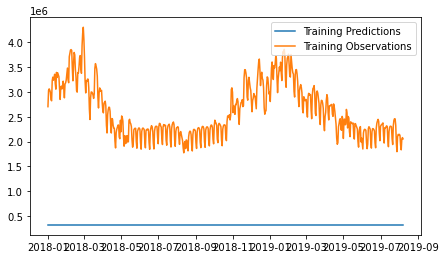

In [18]:

train_predictions = model.predict(X_train).flatten()
plt.figure (figsize=(7,4))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2) 2nd modèle : Données centrées/réduites 

In [19]:
# Comme la seule indiction pour nous mettre sur la voix est la valeur gigantesque de nos mse ... on décide de centrer-reduire nos valriables 

df_uni_cr = df[[ 'Date', 'Consommation (MW)']].groupby(['Date'], as_index=False).sum('Consommation (MW)')

df_date  = df_uni_cr['Date']
df_uni_cr.index = df_uni_cr.pop('Date')

# Centrer réduire 
scaler = StandardScaler()
scaler.fit(df_uni_cr)
df_uni_cr= pd.DataFrame (scaler.transform(df_uni_cr), columns =['Consommation (MW)'])
df_uni_cr.head()
df_uni_cr = pd.concat ([df_uni_cr,df_date],axis=1)

df_uni_cr.index = df_uni_cr.pop('Date')

df_uni_cr.head()

,Consommation (MW)
Date,
2013-01-01,-0.041831
2013-01-02,0.994888
2013-01-03,1.193327
2013-01-04,1.063756
2013-01-05,0.593332


In [20]:
windowed_df = df_to_windowed_df(df_uni_cr,
                                'Consommation (MW)',
                                '2018-01-01', 
                                '2019-12-31', 
                                n=15)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

print (dates.shape, X.shape, y.shape) 

date de début  2018-01-01
date de début  2019-12-31
nombre de mesures : 15
(730,) (730, 14, 1) (730,)


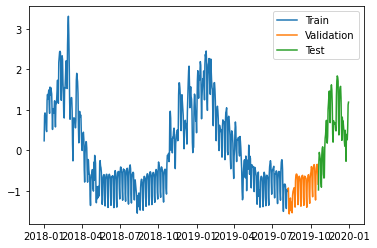

In [21]:
# Préparation des jeux de train test et val 
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [22]:
# Fabrication du model LSTM
model_cr_lstm = Sequential([layers.Input((X.shape[1], 1)),
                    layers.LSTM(128),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(32, activation='linear'),
                    layers.Dense(1)])

model_cr_lstm.summary()

nommodele = 'LSTM_NAT_CR_LSTM'+ str(datetime.datetime.now()).replace (' ','_').replace (':','_').replace ('.','_')

print("nom_du_modele : ", nommodele)

cp  = ModelCheckpoint(nommodele, save_best_only=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________
nom_du_modele :  LSTM_NAT_CR_LSTM2022-07-15_15_00_34_781644


In [23]:
model_cr_lstm.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0001),
              metrics=[MeanSquaredError()])

# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[cp])
model_cr_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000)

Epoch 1/1000
19/19 [==============================] - 2s 33ms/step - loss: 0.8617 - mean_squared_error: 0.8617 - val_loss: 0.5630 - val_mean_squared_error: 0.5630
Epoch 2/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.5388 - mean_squared_error: 0.5388 - val_loss: 0.2982 - val_mean_squared_error: 0.2982
Epoch 3/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.3043 - mean_squared_error: 0.3043 - val_loss: 0.1263 - val_mean_squared_error: 0.1263
Epoch 4/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.2274 - mean_squared_error: 0.2274 - val_loss: 0.0890 - val_mean_squared_error: 0.0890
Epoch 5/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.2186 - mean_squared_error: 0.2186 - val_loss: 0.0889 - val_mean_squared_error: 0.0889
Epoch 6/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.2164 - mean_squared_error: 0.2164 - val_loss: 0.0887 - val_mean_squared_error: 0.0887
Epoch 7/1000
19/19 [=======

19/19 [==============================] - 0s 9ms/step - loss: 0.1157 - mean_squared_error: 0.1157 - val_loss: 0.0751 - val_mean_squared_error: 0.0751
Epoch 102/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1148 - mean_squared_error: 0.1148 - val_loss: 0.0747 - val_mean_squared_error: 0.0747
Epoch 103/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1189 - mean_squared_error: 0.1189 - val_loss: 0.0741 - val_mean_squared_error: 0.0741
Epoch 104/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1154 - mean_squared_error: 0.1154 - val_loss: 0.0737 - val_mean_squared_error: 0.0737
Epoch 105/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1121 - mean_squared_error: 0.1121 - val_loss: 0.0733 - val_mean_squared_error: 0.0733
Epoch 106/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1103 - mean_squared_error: 0.1103 - val_loss: 0.0739 - val_mean_squared_error: 0.0739
Epoch 107/1000
19/19 [=========

Epoch 151/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0920 - mean_squared_error: 0.0920 - val_loss: 0.0595 - val_mean_squared_error: 0.0595
Epoch 152/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0944 - mean_squared_error: 0.0944 - val_loss: 0.0608 - val_mean_squared_error: 0.0608
Epoch 153/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0927 - mean_squared_error: 0.0927 - val_loss: 0.0581 - val_mean_squared_error: 0.0581
Epoch 154/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0562 - val_mean_squared_error: 0.0562
Epoch 155/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0633 - val_mean_squared_error: 0.0633
Epoch 156/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0565 - val_mean_squared_error: 0.0565
Epoch 157/1000


Epoch 201/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0831 - mean_squared_error: 0.0831 - val_loss: 0.0485 - val_mean_squared_error: 0.0485
Epoch 202/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 203/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0806 - mean_squared_error: 0.0806 - val_loss: 0.0509 - val_mean_squared_error: 0.0509
Epoch 204/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0811 - mean_squared_error: 0.0811 - val_loss: 0.0481 - val_mean_squared_error: 0.0481
Epoch 205/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0796 - mean_squared_error: 0.0796 - val_loss: 0.0530 - val_mean_squared_error: 0.0530
Epoch 206/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0787 - mean_squared_error: 0.0787 - val_loss: 0.0488 - val_mean_squared_error: 0.0488
Epoch 207/1000


Epoch 251/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0731 - mean_squared_error: 0.0731 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 252/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0735 - mean_squared_error: 0.0735 - val_loss: 0.0420 - val_mean_squared_error: 0.0420
Epoch 253/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0701 - mean_squared_error: 0.0701 - val_loss: 0.0424 - val_mean_squared_error: 0.0424
Epoch 254/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 255/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0698 - mean_squared_error: 0.0698 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 256/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0684 - mean_squared_error: 0.0684 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 257/1000


Epoch 301/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 302/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0610 - mean_squared_error: 0.0610 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 303/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0610 - mean_squared_error: 0.0610 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 304/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 305/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 306/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 307/

Epoch 351/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - val_loss: 0.0266 - val_mean_squared_error: 0.0266
Epoch 352/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 353/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0569 - mean_squared_error: 0.0569 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 354/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 355/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 356/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 357/10

Epoch 401/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 0.0222 - val_mean_squared_error: 0.0222
Epoch 402/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - val_loss: 0.0221 - val_mean_squared_error: 0.0221
Epoch 403/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0521 - mean_squared_error: 0.0521 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 404/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 405/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 406/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0535 - mean_squared_error: 0.0535 - val_loss: 0.0225 - val_mean_squared_error: 0.0225
Epoch 407/1

Epoch 451/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 452/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 453/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.0201 - val_mean_squared_error: 0.0201
Epoch 454/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.0201 - val_mean_squared_error: 0.0201
Epoch 455/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0265 - val_mean_squared_error: 0.0265
Epoch 456/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 457/

Epoch 501/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 502/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 503/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 504/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 505/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 506/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 507/

Epoch 551/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 552/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 553/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 554/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 555/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 556/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 557/

Epoch 601/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
Epoch 602/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 603/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 604/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 605/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 606/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 607/10

Epoch 651/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 652/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0201 - val_mean_squared_error: 0.0201
Epoch 653/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 654/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 655/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 656/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 657/100

Epoch 701/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 702/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 703/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 704/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0362 - mean_squared_error: 0.0362 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 705/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 706/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 707/1000

Epoch 751/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 752/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 753/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 754/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 755/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 756/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 757/1000

Epoch 801/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 802/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 803/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 804/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 805/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 806/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 807/1000
1

Epoch 851/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 852/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 853/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 854/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 855/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 856/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 857/1000
1

Epoch 901/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 902/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 903/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 904/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
Epoch 905/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 906/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0221 - val_mean_squared_error: 0.0221
Epoch 907/

Epoch 951/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 952/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 953/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 954/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 955/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 956/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 957/10

In [24]:
# # Le meilleur modèle a été sauvegarder dans nommodele.
# model = load_model(nommodele+'/')

19/19 [==============================] - 0s 4ms/step


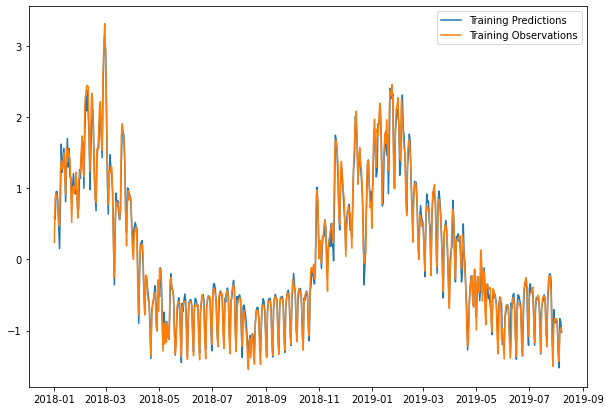

In [25]:
train_predictions = model_cr_lstm.predict(X_train).flatten()
plt.figure (figsize=(10,7))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 4ms/step


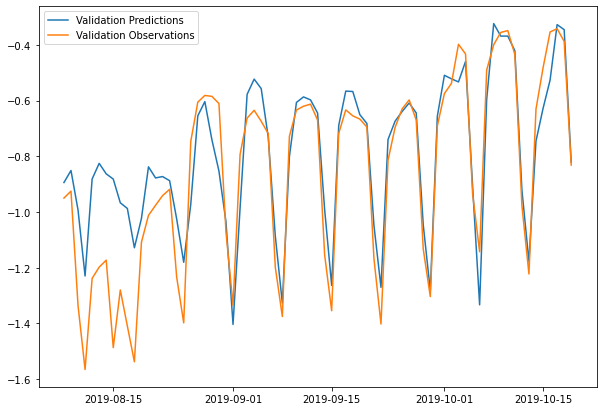

In [26]:
val_predictions = model_cr_lstm.predict(X_val).flatten()
plt.figure (figsize=(10,7))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 4ms/step
MSE sur le train :  0.0226736


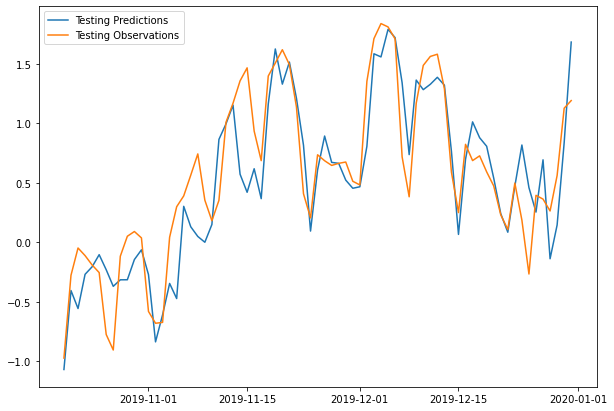

In [27]:
test_predictions = model_cr_lstm.predict(X_test).flatten()
plt.figure (figsize=(10,7))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
print ('MSE sur le train : ' ,mse(y_train, train_predictions) )
plt.legend(['Testing Predictions', 'Testing Observations'])

In [28]:
# Evaluation du modèle 
print ('MSE sur le train : ' ,mse(y_train, train_predictions) )
print ('MSE sur le test : ' ,mse(y_test, test_predictions) )
print ('MSE sur le val : ' ,mse(y_val,  val_predictions) )


MSE sur le train :  0.0226736
MSE sur le test :  0.11641882
MSE sur le val :  0.027897593


In [29]:
# Fabrication du model sur la base d'un CNN
model_cr_CNN = Sequential([layers.Input((X.shape[1], 1)),
                    layers.Conv1D(64, kernel_size=2), # Kernel size décrit comment la couche utilise les mesures (ici 2 à la fois)
                    layers.Flatten(),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1, activation='linear')])

model_cr_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 64)            192       
                                                                 
 flatten (Flatten)           (None, 832)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                53312     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 53,569
Trainable params: 53,569
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_cr_CNN.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0001),
              metrics=[MeanSquaredError()])

model_cr_CNN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100 )

Epoch 1/100
19/19 [==============================] - 1s 9ms/step - loss: 0.4510 - mean_squared_error: 0.4510 - val_loss: 0.1030 - val_mean_squared_error: 0.1030
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2580 - mean_squared_error: 0.2580 - val_loss: 0.0971 - val_mean_squared_error: 0.0971
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2107 - mean_squared_error: 0.2107 - val_loss: 0.0712 - val_mean_squared_error: 0.0712
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1804 - mean_squared_error: 0.1804 - val_loss: 0.0623 - val_mean_squared_error: 0.0623
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.0537 - val_mean_squared_error: 0.0537
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1421 - mean_squared_error: 0.1421 - val_loss: 0.0474 - val_mean_squared_error: 0.0474
Epoch 7/100
19/19 [===============

19/19 [==============================] - 0s 1ms/step


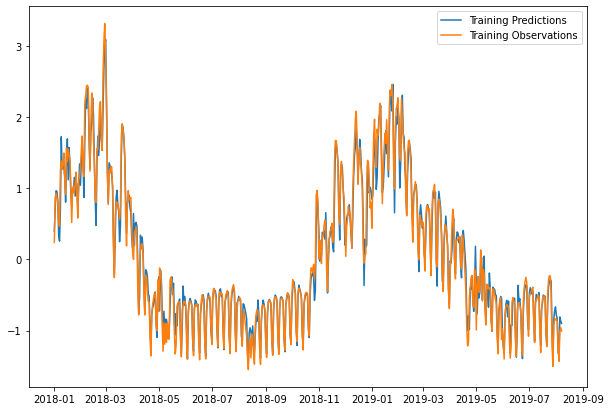

In [31]:
train_predictions = model_cr_CNN.predict(X_train).flatten()
plt.figure (figsize=(10,7))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 1ms/step


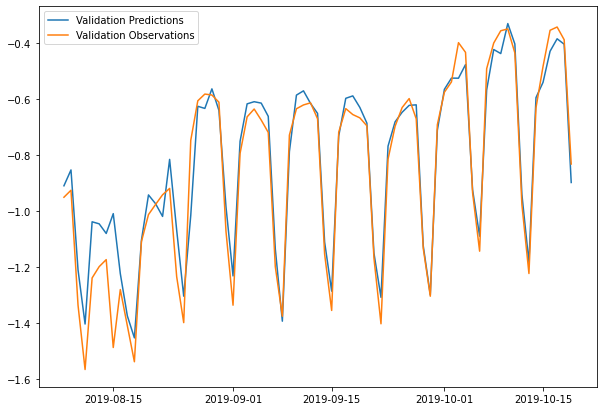

In [32]:
val_predictions = model_cr_CNN.predict(X_val).flatten()
plt.figure (figsize=(10,7))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 2ms/step
MSE sur le train :  0.029695874


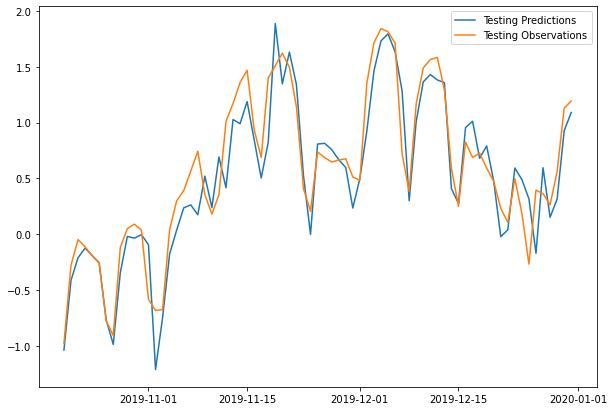

In [33]:
test_predictions = model_cr_CNN.predict(X_test).flatten()
plt.figure (figsize=(10,7))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
print ('MSE sur le train : ' ,mse(y_train, train_predictions) )
plt.legend(['Testing Predictions', 'Testing Observations'])

In [34]:
# Evaluation du modèle 
print ('MSE sur le train : ' ,mse(y_train, train_predictions) )
print ('MSE sur le test : ' ,mse(y_test, test_predictions) )
print ('MSE sur le val : ' ,mse(y_val,  val_predictions) )


MSE sur le train :  0.029695874
MSE sur le test :  0.063785054
MSE sur le val :  0.008555512


**Conclusion** : Le second modèle est meilleur et plus rapide que le premier.  

**C. Modèle avec des données exogènes**  
  
  Nous avons choisi : - Uniquement la température 
                      - Le jour de la semaine (lundi, ....), la température, la nébulosité, la pluviométrie(24H),humidite, vitesse_vent. 
  
  

1) Récupération des données exogène et jointure des dataframe 
Le fichier weather contient les données déja préparées. 


In [35]:
weather = pd.read_csv ('./Data/weather_out.csv', sep=',', index_col=0)
weather.head()


,aaaammjj,annee,mois,joursem,jour,temp,humidite,nebulosite,nebulosite2,rafale_periode,vitesse_vent,pluie_1h,pluie_3h,pluie_6h,pluie_12h,pluie_24h
region,,,,,,,,,,,,,,,,
11,2015-01-01,2015,1,3,1,0.4000,84.250,30.6250,30.625,3.5875,1.8500,0.0,0.0,0.0,0.0,0.0
11,2015-01-02,2015,1,4,2,4.0625,88.375,73.7500,73.750,6.1250,3.2625,0.0,0.2,0.4,0.8,1.2
11,2015-01-03,2015,1,5,3,6.9250,93.125,92.0625,97.625,9.2750,4.5625,0.8,3.0,6.0,10.4,12.2
11,2015-01-04,2015,1,6,4,4.3250,83.750,72.5000,72.500,4.0500,2.2625,0.2,1.2,2.4,6.4,21.8
11,2015-01-05,2015,1,0,5,-0.3875,95.250,77.1250,77.125,2.3875,1.1375,0.0,0.0,0.0,0.0,0.0


In [36]:
# transformation de la date 
weather['aaaammjj'] = pd.to_datetime(weather['aaaammjj'])
print (weather['aaaammjj'].dtypes)

datetime64[ns]


In [37]:
weather = weather.drop (['annee','mois','jour','nebulosite2','rafale_periode','pluie_1h','pluie_3h','pluie_6h','pluie_12h'], axis = 1)

In [38]:
weather.head()

,aaaammjj,joursem,temp,humidite,nebulosite,vitesse_vent,pluie_24h
region,,,,,,,
11,2015-01-01,3,0.4000,84.250,30.6250,1.8500,0.0
11,2015-01-02,4,4.0625,88.375,73.7500,3.2625,1.2
11,2015-01-03,5,6.9250,93.125,92.0625,4.5625,12.2
11,2015-01-04,6,4.3250,83.750,72.5000,2.2625,21.8
11,2015-01-05,0,-0.3875,95.250,77.1250,1.1375,0.0


In [39]:
# Agregation des régions 
weather  = weather.groupby(['aaaammjj','joursem'], as_index=False).agg({'temp': 'mean', 
                                                                        'humidite' : 'mean',
                                                                        'nebulosite' : 'mean',
                                                                        'vitesse_vent': 'mean',
                                                                         'pluie_24h' : 'sum'})


weather.head()

weather['Date_aammjj'] = pd.to_datetime(weather['aaaammjj'])

weather.head()

,aaaammjj,joursem,temp,humidite,nebulosite,vitesse_vent,pluie_24h,Date_aammjj
0,2015-01-01,3,1.468626,80.291209,66.360451,2.776580,6.2,2015-01-01
1,2015-01-02,4,4.806957,83.130632,86.585130,3.219856,115.2,2015-01-02
2,2015-01-03,5,7.857370,88.278195,93.490206,4.459136,496.6,2015-01-03
3,2015-01-04,6,7.904141,84.662912,85.468887,2.888359,834.7,2015-01-04
4,2015-01-05,0,3.871003,86.293269,81.586745,2.352637,48.0,2015-01-05


In [40]:
print(" (weather) Premiere date des données utilisées : " , weather['Date_aammjj'].min())
# 2013-01-01 00:00:00
print("(weather) Derniere date es données utilisées  : " , weather['Date_aammjj'].max())
# 2021-11-30 00:00:00
# # On met la date en index 
weather.index = weather.pop ('aaaammjj')
weather.head()

 (weather) Premiere date des données utilisées :  2015-01-01 00:00:00
(weather) Derniere date es données utilisées  :  2019-12-31 00:00:00


,joursem,temp,humidite,nebulosite,vitesse_vent,pluie_24h,Date_aammjj
aaaammjj,,,,,,,
2015-01-01,3,1.468626,80.291209,66.360451,2.776580,6.2,2015-01-01
2015-01-02,4,4.806957,83.130632,86.585130,3.219856,115.2,2015-01-02
2015-01-03,5,7.857370,88.278195,93.490206,4.459136,496.6,2015-01-03
2015-01-04,6,7.904141,84.662912,85.468887,2.888359,834.7,2015-01-04
2015-01-05,0,3.871003,86.293269,81.586745,2.352637,48.0,2015-01-05


In [41]:
df_uni.head()

,Consommation (MW)
Date,
2013-01-01,2556595
2013-01-02,3095594
2013-01-03,3198764
2013-01-04,3131399
2013-01-05,2886822


In [42]:
df_all= df_uni.join(weather, how='outer' )
df_all = df_all[(df_all['Date_aammjj']>= '2018-01-01') & (df_all['Date_aammjj'] <= '2019-12-31')]

In [43]:
df_all = df_all.drop ('Date_aammjj',axis=1)

In [44]:
df_all.head()

,Consommation (MW),joursem,temp,humidite,nebulosite,vitesse_vent,pluie_24h
2018-01-01,2702491,0.0,8.500962,77.720604,88.684753,7.232157,1750.6
2018-01-02,3028933,1.0,8.830089,81.397802,91.609341,5.277483,1587.3
2018-01-03,3060532,2.0,11.010172,77.247184,92.188187,8.573819,1276.8
2018-01-04,3032111,3.0,11.876802,84.570252,94.207584,7.153412,2757.1
2018-01-05,2991314,4.0,9.832706,84.843681,90.965488,4.226099,1416.7


On centre et reduit nos colonnes 

In [45]:
# On sauvegarde les dates 
mesdates = pd.DataFrame(df_all.index,columns= ['thedate']) 

# On centre reduit tout y compris les jours de la semaine 
scaler = StandardScaler()
scaler.fit(df_all)
df_all_cr= pd.DataFrame (scaler.transform(df_all), columns =['Consommation (MW)','joursem','temp','humidite',
                                                          'nebulosite','vitesse_vent','pluie_24h'])

df_all_cr = pd.concat ([df_all_cr,mesdates],axis=1)

df_all_cr.index = df_all_cr.pop('thedate')

df_all_cr.head(10)

,Consommation (MW),joursem,temp,humidite,nebulosite,vitesse_vent,pluie_24h
thedate,,,,,,,
2018-01-01,0.212680,-1.495304,-0.754408,0.333007,0.539635,3.178389,1.405752
2018-01-02,0.839762,-0.995729,-0.702132,0.726623,1.033163,1.433043,1.190489
2018-01-03,0.900462,-0.496154,-0.355870,0.282331,1.130845,4.376371,0.781187
2018-01-04,0.845867,0.003422,-0.218224,1.066209,1.471621,3.108077,2.732524
2018-01-05,0.767497,0.502997,-0.542887,1.095478,0.924512,0.494252,0.965603
2018-01-06,0.482398,1.002573,-0.854853,1.520868,1.306927,-0.730419,0.613116
2018-01-07,0.439534,1.502148,-0.781311,0.940568,1.544558,2.906983,0.822051
2018-01-08,1.214334,-1.495304,-0.888809,1.038634,1.267788,1.178907,1.216985
2018-01-09,1.354351,-0.995729,-0.987608,1.578977,1.493152,-0.428228,1.199980


In [46]:
X,y = df_to_X_y2_multi(df_all_cr,14)
X.shape ,y.shape

((716, 14, 7), (716,))

In [47]:
q_80 = int(X.shape[0] * .8)
q_90 = int(X.shape[0]  * .9)

dates_train, X_multi_train, y_multi_train = mesdates[:q_80], X[:q_80], y[:q_80]
dates_val,X_multi_val,y_multi_val = mesdates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test,X_multi_test, y_multi_test = mesdates[q_90:], X[q_90:], y[q_90:]
dates_train.shape, X_multi_train.shape, y_multi_train.shape,dates_val.shape, X_multi_val.shape, y_multi_val.shape, dates_test.shape,X_multi_test.shape, y_multi_test.shape

((572, 1),
 (572, 14, 7),
 (572,),
 (72, 1),
 (72, 14, 7),
 (72,),
 (86, 1),
 (72, 14, 7),
 (72,))

In [48]:
# Fabrication du model avec variables exogène sur la base d'un CNN
# model_multi_CNN = Sequential([layers.Input((14,7)),
#                     layers.Conv1D(64, kernel_size=2), # Kernel size décrit comment la couche utilise les mesures (ici 2 à la fois)
#                     layers.Flatten(),
#                     layers.Dense(64, activation='relu'),
#                     layers.Dense(1, activation='linear')])


model_multi_CNN = Sequential()
model_multi_CNN.add(layers.InputLayer((14, 7)))
model_multi_CNN.add(layers.LSTM(64))
model_multi_CNN.add(layers.Dense(8, 'relu'))
model_multi_CNN.add(layers.Dense(1, 'linear'))

model_multi_CNN.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18432     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [49]:
model_multi_CNN.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0001),
              metrics=[MeanSquaredError()])

# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[cp])
model_multi_CNN.fit(X_multi_train, y_multi_train, validation_data=(X_multi_val, y_multi_val), epochs=100)

Epoch 1/100
18/18 [==============================] - 2s 33ms/step - loss: 1.1607 - mean_squared_error: 1.1607 - val_loss: 0.9981 - val_mean_squared_error: 0.9981
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 1.0275 - mean_squared_error: 1.0275 - val_loss: 0.8414 - val_mean_squared_error: 0.8414
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.9338 - mean_squared_error: 0.9338 - val_loss: 0.6617 - val_mean_squared_error: 0.6617
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.8484 - mean_squared_error: 0.8484 - val_loss: 0.5089 - val_mean_squared_error: 0.5089
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 0.7707 - mean_squared_error: 0.7707 - val_loss: 0.4031 - val_mean_squared_error: 0.4031
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 0.6787 - mean_squared_error: 0.6787 - val_loss: 0.3383 - val_mean_squared_error: 0.3383
Epoch 7/100
18/18 [==============

18/18 [==============================] - 0s 3ms/step
MSE sur le train :  0.07090776511104319


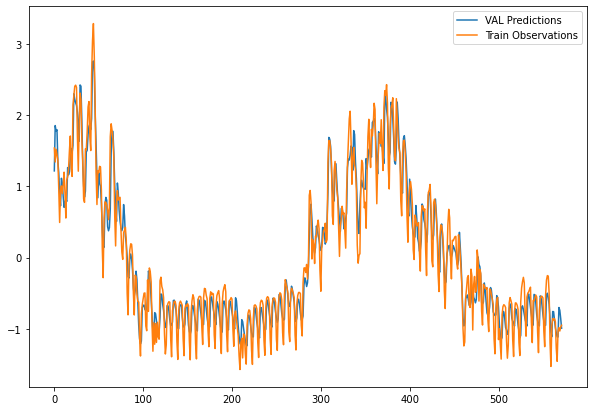

In [50]:
train_multi_predictions = model_multi_CNN.predict(X_multi_train).flatten()
plt.figure (figsize=(10,7))
# print (dates_train.shape , train_predictions.shape)
plt.plot(  train_multi_predictions)
plt.plot( y_multi_train)
print ('MSE sur le train : ' ,mse(y_multi_train, train_multi_predictions) )
plt.legend(['VAL Predictions', 'Train Observations']) 

3/3 [==============================] - 0s 3ms/step
MSE sur val :  0.06084526851116204


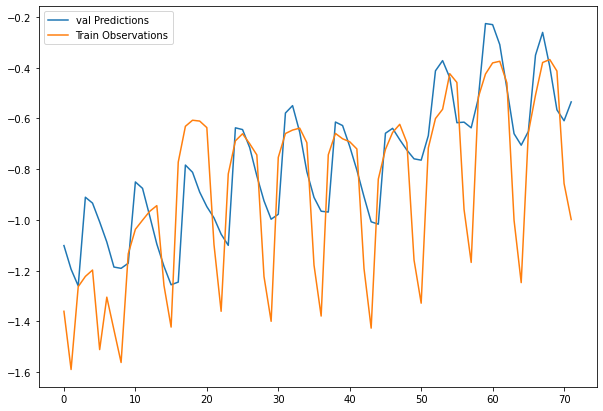

In [51]:
val_multi_predictions = model_multi_CNN.predict(X_multi_val).flatten()
plt.figure (figsize=(10,7))
# print (dates_train.shape , train_predictions.shape)
plt.plot(  val_multi_predictions)
plt.plot( y_multi_val)
print ('MSE sur val : ' ,mse(y_multi_val, val_multi_predictions) )
plt.legend(['val Predictions', 'Train Observations']) 

3/3 [==============================] - 0s 3ms/step
MSE sur le test :  0.1256767988587092


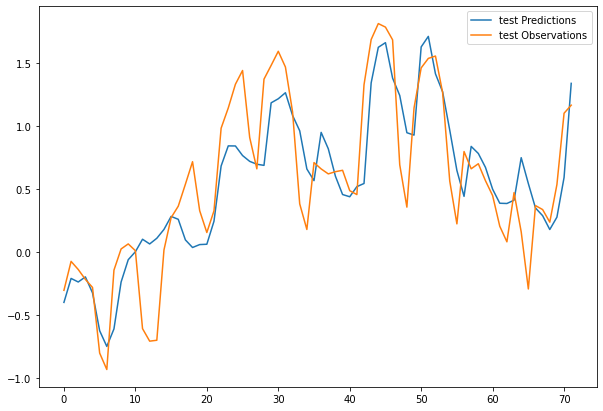

In [52]:
test_multi_predictions = model_multi_CNN.predict(X_multi_test).flatten()
plt.figure (figsize=(10,7))
# print (dates_train.shape , train_predictions.shape)
plt.plot(  test_multi_predictions)
plt.plot( y_multi_test)
print ('MSE sur le test : ' ,mse(y_multi_test, test_multi_predictions) )
plt.legend(['test Predictions', 'test Observations']) 

In [53]:
print ('   ============================== En résumé ========================================\n' )
print ('   ==============================  Sans variables exogènes =========================\n' )
 
print ('MSE sur le train : ' ,mse(y_train, train_predictions) )
print ('MSE sur le test : ' ,mse(y_test, test_predictions) )
print ('MSE sur le val : ' ,mse(y_val,  val_predictions) )

print ('   ==============================  avec  variables exogènes =========================\n' )
print ('MSE sur le train : ' ,mse(y_multi_train, train_multi_predictions) )
print ('MSE sur le test : ' ,mse(y_multi_test, test_multi_predictions) )
print ('MSE sur le val : ' ,mse(y_multi_val,  val_multi_predictions) )

print ('   ============================== En conclusion le modèle  ========================================\n' )
print ('Avec les variables consommation,joursem,temp,humidite,nebulosite,vitesse_vent,pluie_24h ') 
print ('le modèle semble donner de moins bon résultat que sans variables exogènes !')

   ============================== En résumé ========================================

   ==============================  Sans variables exogènes =========================

MSE sur le train :  0.029695874
MSE sur le test :  0.063785054
MSE sur le val :  0.008555512
   ==============================  avec  variables exogènes =========================

MSE sur le train :  0.07090776511104319
MSE sur le test :  0.1256767988587092
MSE sur le val :  0.06084526851116204
   ============================== En conclusion le modèle  ========================================

Avec les variables consommation,joursem,temp,humidite,nebulosite,vitesse_vent,pluie_24h 
le modèle semble donner de moins bon résultat que sans variables exogènes !
